<a href="https://colab.research.google.com/github/micheldc55/Deep-Learning/blob/main/nodulos_pulmon_EJERCICIO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<font color="#CA0032"><h1 align="left">**Redes convolucionales (CNNs)**</h1></font>

<font color="#6E6E6E"><h1 align="left">**Predicción de malignidad en nódulos pulmonares**</h1></font>

<h2 align="left">Manuel Sánchez-Montañés</h2>

<font color="#6E6E6E"><h2 align="left">manuel.smontanes@gmail.com</h2></font>

In [92]:
COLAB = True

In [93]:
if COLAB:
    %tensorflow_version 1.x
    !pip install h5py==2.10.0

In [94]:
# Base de datos y kernel de lectura y visualización de la base de datos obtenidos de:
#
# https://www.kaggle.com/kmader/lungnodemalignancy

import cv2 # pip install opencv-python
import os
import numpy as np
import matplotlib.pyplot as plt
import h5py
import urllib
from sklearn.metrics import confusion_matrix

%matplotlib inline

## **Carga de datos**

In [95]:
!ls

all_patches.hdf5  mi_fichero.pkl  model_current_best_v2.h5  sample_data


In [96]:
if COLAB:
    urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1Oxx1prDWV1e5vLeOAE7_jEdHPbVt6iil",
                               "all_patches.hdf5")

with h5py.File('all_patches.hdf5', 'r') as luna_h5:
    all_slices  = luna_h5['ct_slices'].value
    all_classes = luna_h5['slice_class'].value
    print('shape of all_slices:', all_slices.shape)
    print('shape of classes:   ', all_classes.shape)

shape of all_slices: (6691, 64, 64)
shape of classes:    (6691, 1)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  import sys


In [97]:
!ls -la

total 63320
drwxr-xr-x 1 root root     4096 Oct 30 08:06 .
drwxr-xr-x 1 root root     4096 Oct 30 07:45 ..
-rw-r--r-- 1 root root 64618370 Oct 30 09:11 all_patches.hdf5
drwxr-xr-x 4 root root     4096 Oct 26 13:33 .config
-rw-r--r-- 1 root root      156 Oct 30 07:46 mi_fichero.pkl
-rw-r--r-- 1 root root   200400 Oct 30 08:09 model_current_best_v2.h5
drwxr-xr-x 1 root root     4096 Oct 26 13:34 sample_data


In [98]:
np.unique(all_classes)

array([0., 1.])

In [99]:
def mi_montage2d(data):
    n = len(data)
    lado = int(np.ceil(np.sqrt(n)))
    alto1, ancho1 = data.shape[1:]
    aux = np.zeros((lado*alto1, lado*ancho1))
    for i,image in enumerate(data):
        row = i // lado
        col = i % lado
        aux[(row*alto1):((row+1)*alto1), (col*ancho1):((col+1)*ancho1)] = image
    return aux

In [100]:
def draw_borders(ax, ntiles, tile_width, tile_height, color='r'):
    
    aux1 = int(np.ceil(np.sqrt(ntiles)))
    
    npixels_y = tile_height*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_width - 0.5
        ax.plot([aux2, aux2], [0, npixels_y - 1], color)
        
    npixels_x = tile_width*aux1
    for i in range(aux1-1):
        aux2 = (i+1)*tile_height - 0.5
        ax.plot([0, npixels_x - 1], [aux2, aux2], color)

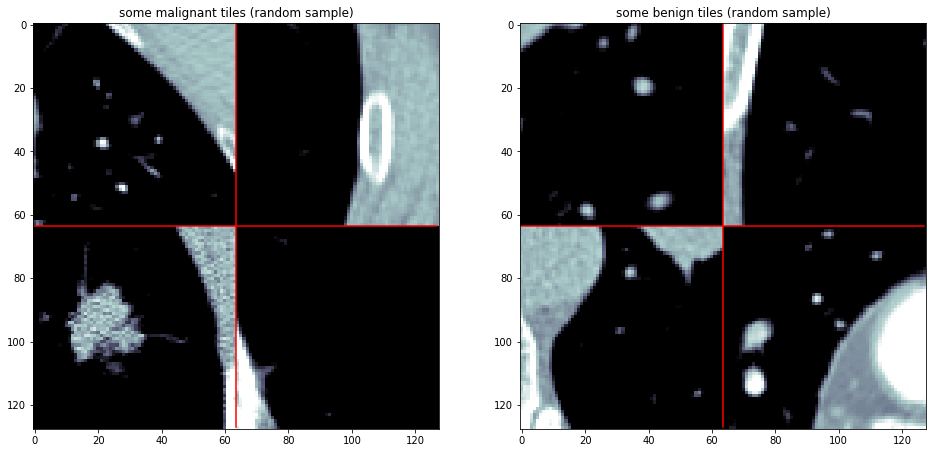

In [101]:
size = 4
fig, (ax1, ax2) = plt.subplots(1,2,figsize = (16, 8))
plt_args = dict(cmap = 'bone', vmin = -600, vmax = 300)
#plt_args = dict(cmap = 'bwr', vmin = -600, vmax = 300)
ax1.imshow(mi_montage2d(all_slices[np.random.choice(np.where(all_classes==1)[0],size=size)]), **plt_args)
ax1.set_title('some malignant tiles (random sample)')
draw_borders(ax1, size, all_slices.shape[1], all_slices.shape[2], 'r')

ax2.imshow(mi_montage2d(all_slices[np.random.choice(np.where(all_classes==0)[0],size=size)]), **plt_args)
ax2.set_title('some benign tiles (random sample)')
draw_borders(ax2, size, all_slices.shape[1], all_slices.shape[2], 'r')

plt.show()

## **Partición y reformateo de datos**

Partiremos los datos en bases de datos de entrenamiento y validación. Recodificaremos la clase con la técnica one-hot.
Se estandarizarán los datos de la imagen.

In [102]:
all_slices.shape

(6691, 64, 64)

all_slices es un array de numpy que indica que hay 6691 imágenes de 64 x 64 pixeles. Si quisiera tomar la primera imagen, tendría que hacer all_slices[0]. Ver debajo que all_slices[0] es una matriz de 64x64

In [103]:
all_slices[0].shape

(64, 64)

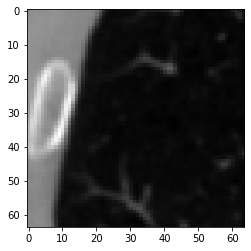

In [104]:
caso = 1000
plt.imshow(all_slices[caso], cmap="gray");

In [105]:
all_slices[caso,63,63]

-926.0

In [106]:
print(all_slices.min(), all_slices.max(), all_slices.mean(), all_slices.std())

-3024.0 3071.0 -588.6012 407.58652


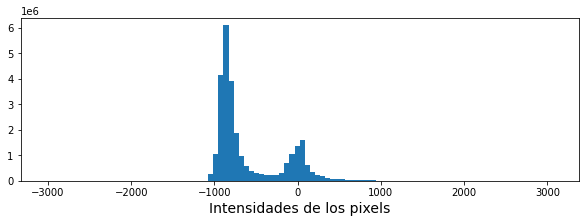

In [107]:
plt.figure(figsize=(10,3))
plt.hist(all_slices.reshape(-1), bins=100) #, density=True)
plt.xlabel('Intensidades de los pixels', fontsize=14)
plt.show()

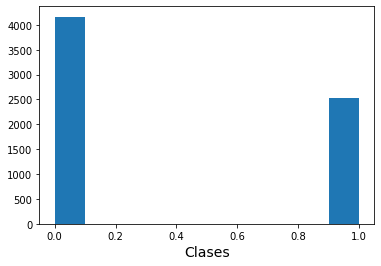

[0. 1.]
[4165 2526]


In [108]:
plt.hist(all_classes)
plt.xlabel('Clases', fontsize=14)
plt.show()

unicos, counts = np.unique(all_classes, return_counts=True)
print(unicos)
print(counts)

In [109]:
prioris_clases = counts / sum(counts)

In [110]:
print(prioris_clases.round(2))

[0.62 0.38]


In [111]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical

#X_vec = (np.expand_dims(all_slices,-1) - np.mean(all_slices))/np.std(all_slices)
X_vec = np.expand_dims(all_slices,-1)
print(all_slices.shape)
X_vec.shape

(6691, 64, 64)


(6691, 64, 64, 1)

In [112]:
all_classes

array([[1.],
       [1.],
       [1.],
       ...,
       [0.],
       [0.],
       [0.]])

In [113]:
y_vec = to_categorical(all_classes)
y_vec

array([[0., 1.],
       [0., 1.],
       [0., 1.],
       ...,
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [114]:
X_train, X_test, y_train, y_test = train_test_split(X_vec, y_vec, 
                                                   train_size = 0.75,
                                                   random_state = 1, 
                                                   stratify = all_classes)

a = np.mean(X_train) # z-score (estandarización)
b = np.std(X_train)

X_train = (X_train - a) / b  # Estoy haciendo la estandarización a mano porque si hiciera estandarización con StandardScaler a cada columna se le aplicaría un valor de media y std dev
X_test  = (X_test  - a) / b  # distinto porque a cada columna le aplica un valor diferente. Por eso lo hago manual!

# Si fuera una matriz RGB, sé que el máximo es 255, así que divido entre 255 y listo!

In [115]:
a, b

(-589.3111, 407.19113)

In [116]:
# imagen entre 0 y 255
# imagen / imagen.mean() # lo que va a hacer es que el promedio de la imagen es 1

In [117]:
all_classes.shape, y_vec.shape

((6691, 1), (6691, 2))

In [118]:
import pickle

with open('mi_fichero.pkl', 'wb') as f:
    pickle.dump({"media":a, "std":b}, f)

In [119]:
# En explotación:
with open('mi_fichero.pkl', 'rb') as f:
    normalizacion = pickle.load(f)

In [120]:
normalizacion

{'media': -589.3111, 'std': 407.19113}

In [121]:
a2 = normalizacion["media"]
b2 = normalizacion["std"]

print(a, b)
print(a2, b2)

-589.3111 407.19113
-589.3111 407.19113


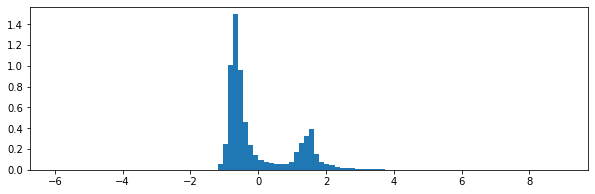

In [122]:
plt.figure(figsize=(10,3))
plt.hist(X_train.reshape(-1), bins=100, density=True)
plt.show()

## **Modelo Dummy (baseline)**

In [123]:
# Aplanado de las soluciones:
X_tr = X_train.reshape((len(X_train), -1))
X_te = X_test.reshape((len(X_test), -1))

print("X_train shape:", np.shape(X_train))
print("X_tr shape:   ", np.shape(X_tr))
print("X_test shape: ", np.shape(X_test))
print("X_te shape:   ", np.shape(X_te))

X_train shape: (5018, 64, 64, 1)
X_tr shape:    (5018, 4096)
X_test shape:  (1673, 64, 64, 1)
X_te shape:    (1673, 4096)


In [124]:
np.shape(y_train)

(5018, 2)

In [125]:
from sklearn.dummy import DummyClassifier

clf = DummyClassifier(strategy="most_frequent")
clf.fit(X_tr, np.argmax(y_train,1))
print('Train accuracy:', clf.score(X_tr, np.argmax(y_train,1)))
print('Test accuracy :', clf.score(X_te, np.argmax(y_test,1)))

Train accuracy: 0.6225587883618972
Test accuracy : 0.6222355050806934


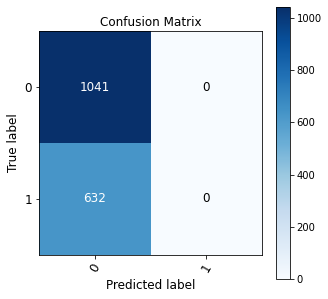

In [126]:
try:
    from scikitplot.metrics import plot_confusion_matrix
except:
    !pip install scikit-plot
    from scikitplot.metrics import plot_confusion_matrix

plot_confusion_matrix(y_test.argmax(1), clf.predict(X_te),
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');


              precision    recall  f1-score   support

           0       0.62      1.00      0.77      1041
           1       0.00      0.00      0.00       632

    accuracy                           0.62      1673
   macro avg       0.31      0.50      0.38      1673
weighted avg       0.39      0.62      0.48      1673



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


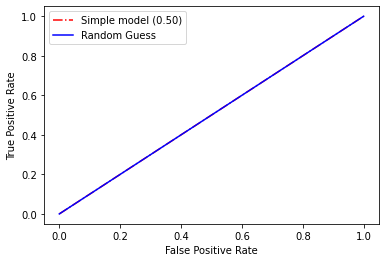

In [127]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            clf.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), clf.predict_proba(X_te)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend()
plt.show()

## **Modelo shallow: regresión logística**

In [128]:
X_train.shape

(5018, 64, 64, 1)

In [129]:
y_train[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [130]:
from sklearn.linear_model import LogisticRegression

model2 = LogisticRegression()
model2.fit(X_tr, np.argmax(y_train,1))

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [131]:
print('Train accuracy:', model2.score(X_tr, np.argmax(y_train,1)))
print('Test accuracy :', model2.score(X_te, np.argmax(y_test,1)))

Train accuracy: 0.8848146671980869
Test accuracy : 0.7537358039450089


In [132]:
np.argmax(y_test,1)

array([1, 0, 1, ..., 1, 1, 0])

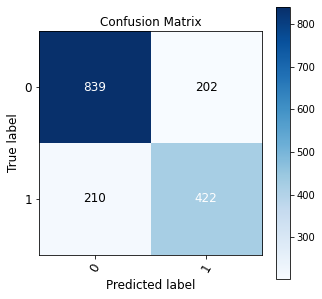

In [133]:
plot_confusion_matrix(y_test.argmax(1), model2.predict(X_te),
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');


              precision    recall  f1-score   support

           0       0.80      0.81      0.80      1041
           1       0.68      0.67      0.67       632

    accuracy                           0.75      1673
   macro avg       0.74      0.74      0.74      1673
weighted avg       0.75      0.75      0.75      1673



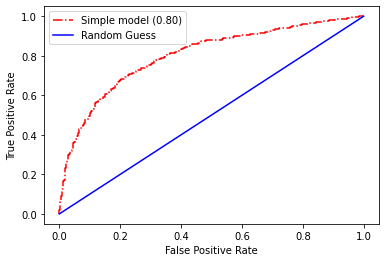

In [134]:
from sklearn.metrics import classification_report, roc_curve, auc

print('')
print(classification_report(np.argmax(y_test,1),
                            model2.predict(X_te)))

fpr, tpr, thresholds = roc_curve(np.argmax(y_test, 1), model2.predict_proba(X_te)[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'Simple model (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

# **Definición de la arquitectura CNN**

Entrenaremos el modelo desde cero. Otra posibilidad es utilizar modelos pre entrenados (transfer learning).

In [135]:
# rellenar con imports de Keras

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [136]:
print("X_train shape:", np.shape(X_train))
print("X_test shape: ", np.shape(X_test))
print("y_train shape:", np.shape(y_train))
print("y_test shape: ", np.shape(y_test))

X_train shape: (5018, 64, 64, 1)
X_test shape:  (1673, 64, 64, 1)
y_train shape: (5018, 2)
y_test shape:  (1673, 2)


In [137]:
# Celdas para probar conceptos (convoluciones, maxpoolings)

In [138]:
model = Sequential()
model.add(Conv2D(filters=10, input_shape=X_train.shape[1:], padding="same",
                 kernel_size=(3,3), activation='relu'))
model.compile(loss='categorical_crossentropy', optimizer='adam')

# El parámetro "padding = 'same'" agrega ceros para que el filtro kernel que estoy usando no se cargue filas. Si borro el 'padding' me va a sacar una imagen de 62x62 porque uso
# un filtro de 3x3 (verlo en el ejemplo de la "T" del pdf)

In [139]:
X_train.shape

(5018, 64, 64, 1)

In [140]:
X_train[caso].shape

(64, 64, 1)

In [141]:
X_train[caso:(caso+1)].shape

(1, 64, 64, 1)

In [142]:
pesos = model.layers[0].get_weights()
len(pesos)

2

In [143]:
print(pesos[0].shape)
print(pesos[1].shape)

(3, 3, 1, 10)
(10,)


In [144]:
pesos[0][:,:,0,0] = 0
pesos[0][0,:,0,0] = 1 # primera fila
pesos[0][1,:,0,0] = -1 # segunda fila

In [145]:
model.layers[0].set_weights(pesos)

In [146]:
caso = 0
salida = model.predict(X_train[caso:(caso+1)])
salida.shape

(1, 64, 64, 10)

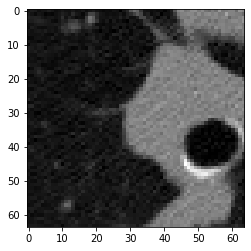

In [147]:
plt.imshow(X_train[caso][:,:,0], cmap="gray");

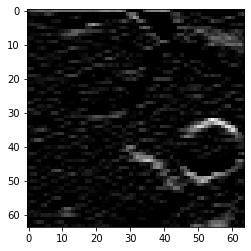

In [148]:
plt.imshow(salida[0][:,:,0], cmap="gray");

In [149]:
y_train[:5]

array([[1., 0.],
       [0., 1.],
       [1., 0.],
       [1., 0.],
       [1., 0.]], dtype=float32)

In [150]:
y_test

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [151]:
X_tr.shape

(5018, 4096)

In [152]:
X_train.shape

(5018, 64, 64, 1)

In [153]:
input_shape = X_train.shape[1:]
input_shape

(64, 64, 1)

In [154]:
y_train.shape

(5018, 2)

In [155]:
num_classes = 2

In [156]:
input_shape

(64, 64, 1)

In [157]:
from keras.layers import GlobalAveragePooling2D, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam
from keras.regularizers import l2
from keras.models import load_model, Model
from keras import backend as K

In [158]:
# Rellenar arquitectura de la red:
# filters: se mantiene o va subiendo en diferentes capas convolutivas
#kernel_size: se mantiene o va bajando en diferentes capas convolutivas

model = Sequential()

p_dropout = 0.2

model.add(Dropout(rate=p_dropout, input_shape=(64,64,1))) # El dropout layer es una forma de introducir ruido. Elimina aleatoriamente variables (en este caso pixeles) y por lo tanto
                                                    # introduce "niebla" en la imagen. Por lo tanto el sistema pierde detalles, pero permite obtener conceptos generales de cada imagen
                                                    # al eliminar esos detalles. El 50% de dropout parece mucho, pero en realidad hay que pensar que muchos píxeles están vinculados
                                                    # y por lo tanto no sería tan problemático.
                                                    # Puedo ver en estos casos que validación va incluso mejor que train, esto es porque el modelo introduce el dropout solo en train!
                                                    # Esto en realidad no es real, porque si después evalúo mi modelo en train sin el Dropout el resultado va a ser mucho mejor
model.add(Conv2D(filters=8, input_shape=(64, 64, 1),
                 kernel_size=(5,5), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(rate=p_dropout))

model.add(Conv2D(filters=8,kernel_size=(3,3),activation='relu'))  # Ahora las imágenes son de 30x30 (porque no hice padding) así que bajo el kernel_size para mantener el 10%
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dropout(rate=p_dropout)) # Esta va después del Flatten porque entre el MaxPooling y el Flatten no cambia nada en los datos, solamente se vectorizan

model.add(Dense(8, activation='relu', 
                #kernel_regularizer=l2(0.01)
                )) # Le pongo la regularización a esta capa porque (ver summary) es la capa que introduce más parámetros (porque conecta todas las neuronas de entrada con las de salida)
model.add(Dropout(rate=p_dropout)) # Le ponemos como prueba dropout en todas las capas.

model.add(Dense(2, activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=1/1000),
              metrics=["accuracy"])


In [159]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 8)         208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)             

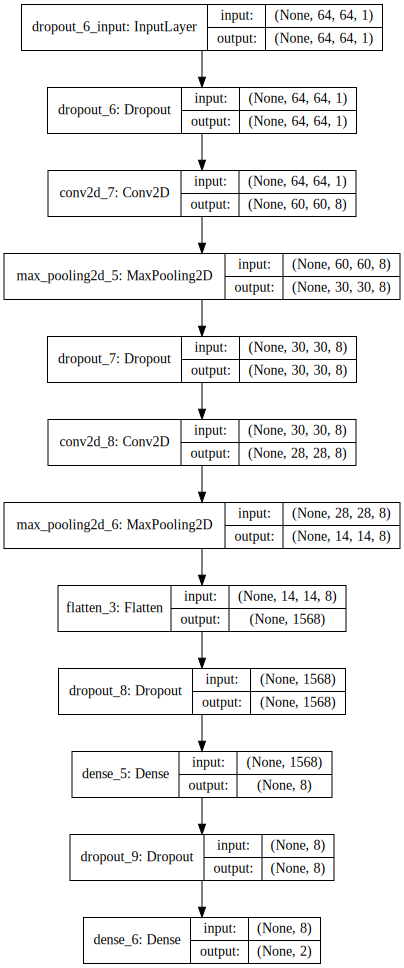

In [160]:
# graphviz
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
SVG(model_to_dot(model, show_shapes=True, dpi=72
                 ).create(prog='dot', format='svg'))

# **Entrenamiento del modelo CNN**

In [161]:
from matplotlib.ticker import MaxNLocator

def grafica_entrenamiento(tr_acc, val_acc, tr_loss, val_loss, best_i,
                          figsize=(10,4)):
    
    plt.figure(figsize=figsize)
    ax = plt.subplot(1,2,1)
    plt.plot(1+np.arange(len(tr_acc)),  100*np.array(tr_acc))
    plt.plot(1+np.arange(len(val_acc)), 100*np.array(val_acc))
    plt.plot(1+best_i, 100*val_acc[best_i], 'or')
    plt.title('tasa de acierto del modelo (%)', fontsize=18)
    plt.ylabel('tasa de acierto (%)', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))

    plt.subplot(1,2,2)
    plt.plot(1+np.arange(len(tr_acc)), np.array(tr_loss))
    plt.plot(1+np.arange(len(val_acc)), np.array(val_loss))
    plt.plot(1+best_i, val_loss[best_i], 'or')
    plt.title('loss del modelo', fontsize=18)
    plt.ylabel('loss', fontsize=18)
    plt.xlabel('época', fontsize=18)
    plt.legend(['entrenamiento', 'validación'], loc='upper left')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    plt.show()

In [162]:
acum_tr_acc   = []
acum_val_acc  = []
acum_tr_loss  = []
acum_val_loss = []

In [163]:
from IPython.display import clear_output
from keras.callbacks import ModelCheckpoint

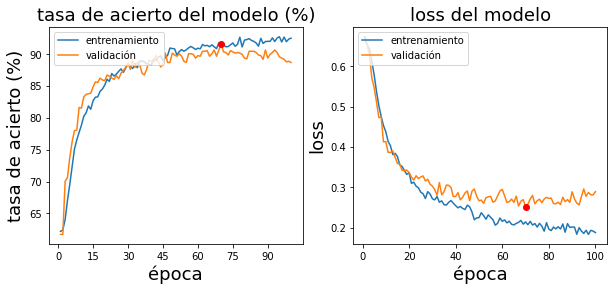

In [164]:
LOAD_MODEL = False

# ESTO SE USA EN LUGAR DE ENTRENAR TODO JUNTO, PARA MONITORIZAR ÉPOCA A ÉPOCA GRÁFICAMENTE

Ntr = 4000

epochs = 100
batch_size = 16  # El batch size no se pone ni muy bajo ni muy alto. El batch size es la cantidad de imágenes que voy a estar usando para hacer una actualización a los pesos del 
                 # modelo y por tanto determina cuantas veces se actualiza el modelo por época. Generalmetne no se juega mucho con este parámetro. Se pone a 16, 32, 64 normalmente

X_tr  = X_train[:Ntr]
y_tr  = y_train[:Ntr]
X_val = X_train[Ntr:]
y_val = y_train[Ntr:]

if not LOAD_MODEL:
    filepath="model_current_best_v2.h5"
    
    checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1,
                                 save_best_only=True,
                                 mode='max') # graba sólo los que mejoran en validación

    # Si quiero monitorizar el log loss:
    #checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
    #                             save_best_only=True,
    #                             mode='min') # Ojo que el mode cambió ahora a min. Ahora no quiero maximizar el accuracy, quiero minimizar el error (log loss)

    callbacks_list = [checkpoint]
    
    for e in range(epochs):
        history = model.fit(X_tr, y_tr, 
                            batch_size=batch_size,
                            epochs=1,
                            callbacks=callbacks_list,
                            # sample_weight({})  # Le paso un diccionario con los pesos de cada clase. Es lo mismo que hacer abajo lo de los costes pero directo en el modelo
                            verbose=1,
                            validation_data=(X_val, y_val))
        
        acum_tr_acc.append(history.history['accuracy'][0])
        acum_val_acc.append(history.history['val_accuracy'][0])
        acum_tr_loss.append(history.history['loss'][0])
        acum_val_loss.append(history.history['val_loss'][0])

        if e % 10 == 0:
          print('10 went by')
        
        if len(acum_tr_acc) > 1:
            clear_output()
            best_i = np.argmax(acum_val_acc)
            grafica_entrenamiento(acum_tr_acc, acum_val_acc, acum_tr_loss, acum_val_loss, best_i)

In [165]:
!ls -la

total 63320
drwxr-xr-x 1 root root     4096 Oct 30 08:06 .
drwxr-xr-x 1 root root     4096 Oct 30 07:45 ..
-rw-r--r-- 1 root root 64618370 Oct 30 09:11 all_patches.hdf5
drwxr-xr-x 4 root root     4096 Oct 26 13:33 .config
-rw-r--r-- 1 root root      156 Oct 30 09:11 mi_fichero.pkl
-rw-r--r-- 1 root root   200456 Oct 30 09:14 model_current_best_v2.h5
drwxr-xr-x 1 root root     4096 Oct 26 13:34 sample_data


# **Resultados obtenidos por el modelo CNN**

In [166]:
if LOAD_MODEL:
    if COLAB:
        urllib.request.urlretrieve("https://drive.google.com/uc?export=download&id=1UKpxwZsfPAp0kHywBucwWBtkxYAXy0lq",
                                   "modelo_entrenado.h5")
    model = load_model('./modelo_entrenado.h5')
else:
    model = load_model('model_current_best_v2.h5')

In [167]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6 (Dropout)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 8)         208       
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 8)         0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 30, 30, 8)         0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 28, 28, 8)         584       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 1568)             

In [168]:
score_tr = model.evaluate(X_tr, y_tr, verbose=0)
print('Train loss    :', score_tr[0])
print('Train accuracy:', score_tr[1])  # Ver que ahora el accuracy es mucho más alto porque no estoy usando el dropout

score_val = model.evaluate(X_val, y_val, verbose=0)
print('Val loss    :', score_val[0])
print('Val accuracy:', score_val[1])

score_te = model.evaluate(X_test, y_test, verbose=0)
print('Test loss     :', score_te[0])
print('Test accuracy :', score_te[1])

Train loss    : 0.0837882072776556
Train accuracy: 0.9789999723434448
Val loss    : 0.2514923950309603
Val accuracy: 0.9155206084251404
Test loss     : 0.25545099860383447
Test accuracy : 0.8995816111564636


In [169]:
model.predict(X_test[:5])

array([[2.5796704e-04, 9.9974197e-01],
       [6.4566648e-01, 3.5433352e-01],
       [1.0133854e-01, 8.9866149e-01],
       [5.8198613e-01, 4.1801387e-01],
       [9.9796450e-01, 2.0355124e-03]], dtype=float32)

In [170]:
y_test[:5]

array([[0., 1.],
       [1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [171]:
umbral_decision_maligno = 0.15 # 0.4, 0.3, 0.2 ... Por qué hago esto? Porque quiero minimizar los falsos negativos. Prefiero equivocarme y decirle que tiene y después no tenga

In [172]:
alarmas = 1*(model.predict(X_test)[:,1]>umbral_decision_maligno)
alarmas[:5]

array([1, 1, 1, 1, 0])

In [173]:
clases_test = y_test.argmax(1) # clase real test --> Estoy convirtiendo la variable y_test que es de 2 dimensiones de ancho a una sola variable. Es como si hiciera un drop_first
                               # en el get_dummies de pandas

In [174]:
confusion_matrix(clases_test, alarmas)

array([[762, 279],
       [ 30, 602]])

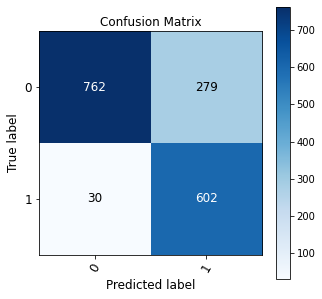

In [175]:
# en el siguiente cálculo y en adelante es equivalente
# a asumir que umbral_decision_maligno = 0.5
plot_confusion_matrix(y_test.argmax(1), alarmas,
                      x_tick_rotation=60, figsize=(5,5),
                      text_fontsize='large');

### ¿Cuál es el umbral óptimo si sé los costes de los errores?

In [176]:
prob_maligno = model.predict(X_val)[:,1]
prob_maligno

array([0.24839514, 0.2380204 , 0.00855552, ..., 0.5442122 , 0.39628157,
       0.08827116], dtype=float32)

In [177]:
y_val[:5]

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [178]:
def analisis_costes(model, X, y,
                    clase_positiva, coste_falso_positivo, coste_falso_negativo):
    prob_positivo = model.predict(X)[:,clase_positiva]
    umbrales = sorted(np.unique(prob_positivo))
    coste_total = []
    n_positivos_en_alarmas = []
    n_positivos_fuera_de_alarmas = []
    n_negativos_en_alarmas = []
    costes = []
    coste_FP = coste_falso_positivo
    coste_FN = coste_falso_negativo

    for umbral in umbrales:
      aux = prob_positivo > umbral #array de 1018 booleanos
      n_positivos_en_alarmas.append(sum(y[aux,clase_positiva])) # aciertos en casos que son alarmas
      n_negativos_en_alarmas.append(sum(1-y_val[aux,clase_positiva])) # fallos en casos que son alarma, FALSOS POSITIVOS
      n_positivos_fuera_de_alarmas.append(sum(y_val[~aux,clase_positiva])) # FALSOS NEGATIVOS
      costes.append(coste_FP*n_negativos_en_alarmas[-1] + coste_FN*n_positivos_fuera_de_alarmas[-1])

    plt.plot(umbrales, n_positivos_en_alarmas, label="positivos que son alarmas")
    plt.plot(umbrales, n_negativos_en_alarmas, label="negativos que son alarmas")
    plt.plot(umbrales, n_positivos_fuera_de_alarmas, label="positivos que NO son alarmas")
    plt.xlabel("umbral alarma")

    plt.legend();
    plt.show()
    plt.plot(umbrales, costes, label="COSTE TOTAL")
    plt.legend()
    plt.xlabel("umbral alarma")
    plt.show()

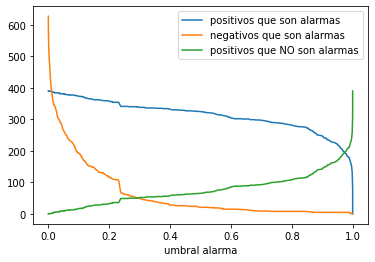

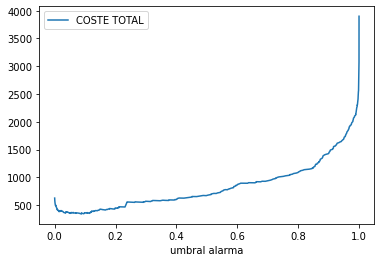

In [179]:
analisis_costes(model, X_val, y_val, clase_positiva=1, coste_falso_positivo=1, coste_falso_negativo=10)
# La gráfica de abajo es la del coste de ambos (FP + FN). Ver que es casi cero, o sea que cuando tenga una probabilidad baja de tener cancer, ya lo mando a hacer estudios

Exagerando el coste de los falsos positivos para ver cómo se compporta la red. Deberíamos esperar que para este caso el coste total fuera mucho menor cuando todos mis valores son falsos positivos.

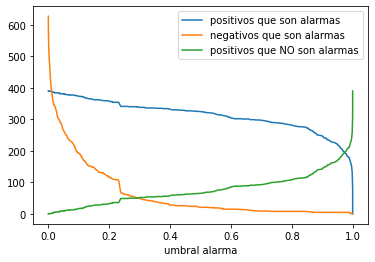

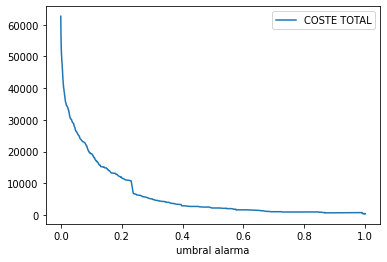

In [193]:
# Hago lo mismo para cuando los falsos positivos son lo más importante y veo que si le doy mucho peso, me conviene elegir que nunca tiene cancer, que no tiene sentido
analisis_costes(model, X_val, y_val, clase_positiva=1, coste_falso_positivo=100, coste_falso_negativo=1)

In [194]:
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba,1)
print('')
print(classification_report(clases_test, y_pred))


              precision    recall  f1-score   support

           0       0.89      0.95      0.92      1041
           1       0.91      0.81      0.86       632

    accuracy                           0.90      1673
   macro avg       0.90      0.88      0.89      1673
weighted avg       0.90      0.90      0.90      1673



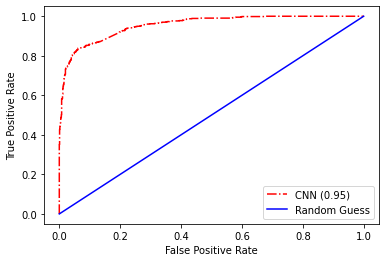

In [195]:
fpr, tpr, thresholds = roc_curve(clases_test, y_pred_proba[:,1])
fig, ax1 = plt.subplots(1,1)
ax1.plot(fpr, tpr, 'r-.', label = 'CNN (%2.2f)' % auc(fpr, tpr))
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.plot(fpr, fpr, 'b-', label = 'Random Guess')
ax1.legend();

# **Análisis de los pesos de la primera capa**

In [196]:
weights = model.get_weights()
print(np.shape(weights))
for i in range(len(weights)):
    print('shape of weights[%d]: ' % i, np.shape(weights[i]))

(8,)
shape of weights[0]:  (5, 5, 1, 8)
shape of weights[1]:  (8,)
shape of weights[2]:  (3, 3, 8, 8)
shape of weights[3]:  (8,)
shape of weights[4]:  (1568, 8)
shape of weights[5]:  (8,)
shape of weights[6]:  (8, 2)
shape of weights[7]:  (2,)


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [197]:
model.layers[1].get_weights()[0].shape, model.layers[1].get_weights()[1].shape

((5, 5, 1, 8), (8,))

Esto de arriba son los parámetros de la segunda capa. El primero elemento son los filtros que obtuve (ver que son de 5x5x1 porque tengo profundidad = 1) y el segundo elemento son los biases de la primera capa.

Debajo estamos generando un predictor pero en base a las capas intermedias. Es como que estuviera cortando el modelo en partes:

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dropout_6_input (InputLayer) (None, 64, 64, 1)         0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 60, 60, 8)         208       
Total params: 208
Trainable params: 208
Non-trainable params: 0
_________________________________________________________________


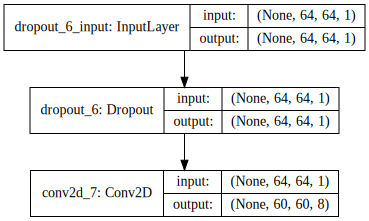

In [184]:
capa = 1 # 4
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[capa].output)
intermediate_layer_model.summary()
SVG(model_to_dot(intermediate_layer_model,show_shapes=True,dpi=72).create(prog='dot', format='svg'))

In [185]:
id_imagen = 2
imagen = X_test[id_imagen,:,:,0]
salidas_capa0 = intermediate_layer_model.predict(imagen.reshape([1,imagen.shape[0],
                                                                 imagen.shape[1],1]))

In [186]:
salidas_capa0.shape

(1, 60, 60, 8)

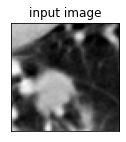

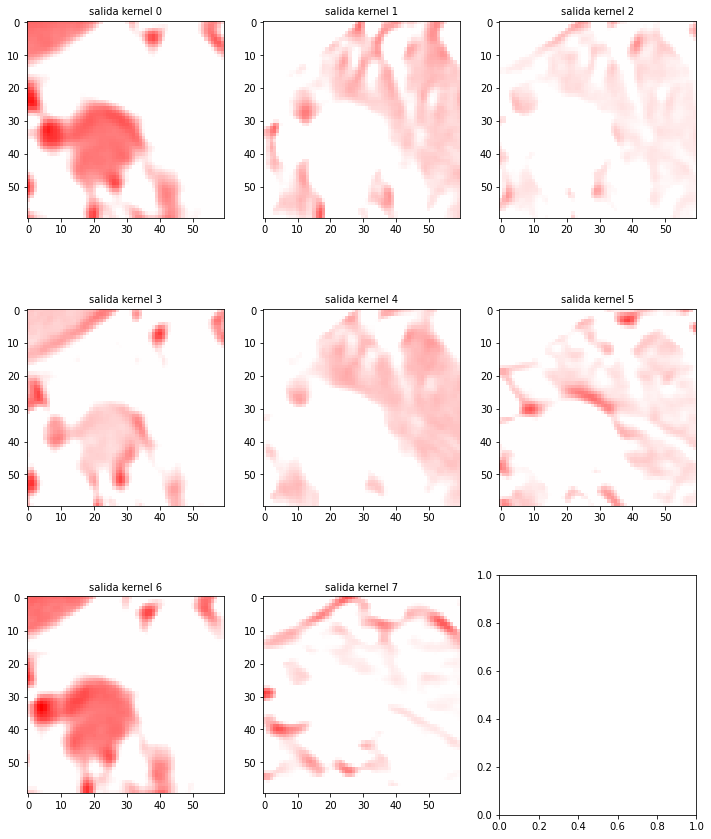

In [187]:
lado = 3
plt.figure(figsize=(2,2))
plt.imshow(imagen, cmap='gray')
plt.title('input image', size=12)
plt.xticks(())
plt.yticks(())
plt.show()

plt.subplots(lado,lado,figsize = (12, 15))

ma = abs(salidas_capa0).max()

columnas = 3
filas = int(np.ceil(salidas_capa0.shape[-1] / columnas))
for i in range(salidas_capa0.shape[-1]):
    plt.subplot(filas,columnas,i+1)
    plt.imshow(salidas_capa0[0,:,:,i], vmin=-ma, vmax=ma, cmap='bwr')
    plt.title('salida kernel %d' % i, fontsize=10)
plt.show()

### **¿A qué partes de la imagen de entrada es más sensible la salida de la red?**

### **GradCam:**

(de https://medium.com/analytics-vidhya/visualizing-activation-heatmaps-using-tensorflow-5bdba018f759)

1- Calcular para una imagen la salida del modelo y la salida de la última capa convolucional

2- Encuentrar la neurona de salida más activa (que es la que determina la clase predicha)

3- Calcular el gradiente de dicha neurona de salida con respecto a la última capa convolucional

3- Promediar y pesar esto con la salida de la última capa convolucional

4- Normalizar entre 0 y 1 para visualizar

5- Convertir a RGB y superponerla a la imagen original

**Funciones que calculan la sensibilidad de la salida a la entrada:**

In [188]:
def find_ind_last_conv2D(model):
    ind_last_conv2D_layer = None
    for i,x in enumerate(model.layers):
        if x.__class__.__name__ == "Conv2D":
            ind_last_conv2D_layer = i
    return ind_last_conv2D_layer

In [189]:
ind_last_conv2D_layer = find_ind_last_conv2D(model)
ind_last_conv2D_layer

4

In [190]:
model.layers[ind_last_conv2D_layer]

In [191]:
def show_heatmap(model, im, es_maligna):
    imag = np.reshape(im, (1, im.shape[0], im.shape[1], im.shape[2]))
        
    # This is the "benign" entry in the prediction vector
    output = model.output[:, 0]
    
    # The is the output feature map of the last convolutional layer
    last_conv_layer = model.layers[find_ind_last_conv2D(model)]
    
    # This is the gradient of the "benign" class with regard to
    # the output feature map of last convolutional layer
    grads = K.gradients(output, last_conv_layer.output)[0]
    
    # This is a vector where each entry
    # is the mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, axis=(0, 1, 2))
    
    # This function allows us to access the values of the quantities we just defined:
    # `pooled_grads` and the output feature map of the last convolutional layer
    # given a sample image
    iterate = K.function([model.input], [pooled_grads, last_conv_layer.output[0]])
    
    # These are the values of these two quantities, as Numpy arrays,
    # given our sample image
    pooled_grads_value, conv_layer_output_value = iterate([imag])
    
    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the output of the model
    for i in range(conv_layer_output_value.shape[-1]):
        conv_layer_output_value[:,:,i] *= pooled_grads_value[i]
    
    # The channel-wise mean of the resulting feature map
    # is our heatmap of class activation
    heatmap = np.mean(conv_layer_output_value, axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    plt.matshow(heatmap)
    plt.show()
    
    
    # We use cv2 to load the original image
    #img = cv2.imread(img_path)
    img = imag[0]
    
    img = np.zeros((im.shape[0],im.shape[1],3))
#    print(im.shape, imag.shape)
    for i in range(3):
        img[:,:,i] = imag[0,:,:,0]

    
    # We resize the heatmap to have the same size as the original image
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    
    # We convert the heatmap to RGB
    heatmap = np.uint8(255 * heatmap)
    
    # We apply the heatmap to the original image
    #heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_HOT)
    
    img = np.maximum(img, -2)
    img = np.minimum(img,  2)
    img = (img+2)/4;
    # 0.4 here is a heatmap intensity factor
    superimposed_img = heatmap * 0.2 / 255 + 0.8*img
    #print(heatmap.min(), heatmap.max(), heatmap.mean(), heatmap.std())
    #print(img.min(), img.max(), img.mean(), img.std())
    #print(superimposed_img.min(),  superimposed_img.max(),
    #      superimposed_img.mean(), superimposed_img.std())
    
    plt.figure(figsize=(15,5))
    plt.subplot(1,3,1)
    plt.imshow(img, vmin=0, vmax=1)
    plt.subplot(1,3,2)
    plt.imshow(heatmap, vmin=0, vmax=1)
    plt.colorbar()
    plt.subplot(1,3,3)
    plt.imshow(superimposed_img, vmin=0, vmax=1)
    plt.show()
    #print(np.shape(imag))
    print("- Probabilidad clase maligna:", model.predict(imag)[0][1])
    print("-", "Clase real:", "maligna" if es_maligna else "benigna")
    print("\n\n\n")
    return heatmap, superimposed_img

**Visualización de mapas de sensibilidades (heatmaps) en varios ejemplos:**

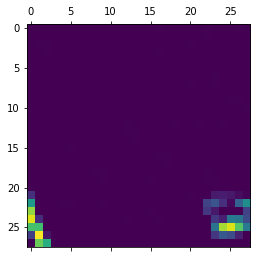

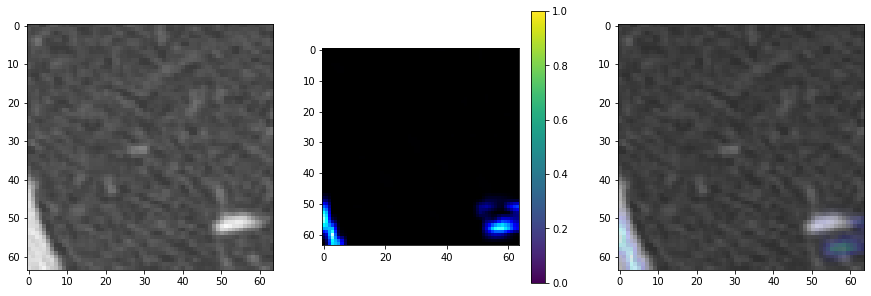

- Probabilidad clase maligna: 0.999742
- Clase real: maligna






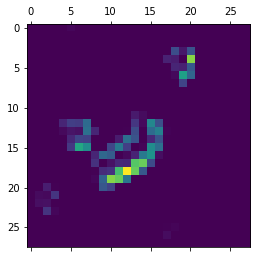

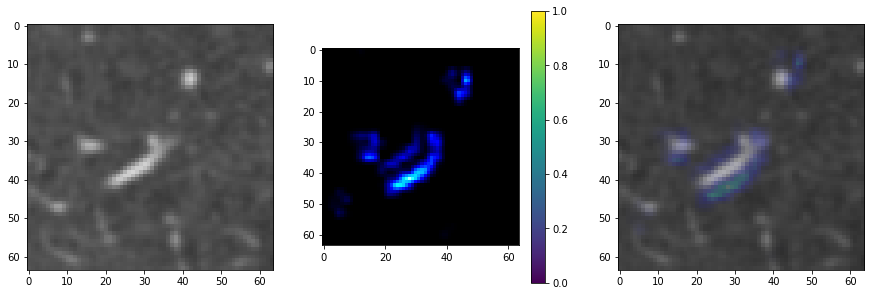

- Probabilidad clase maligna: 0.35433352
- Clase real: benigna






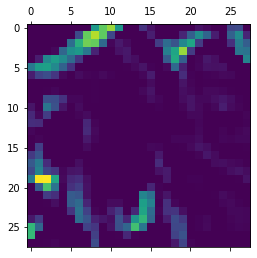

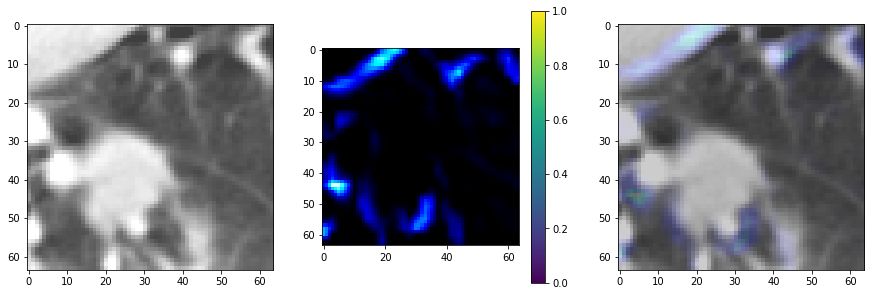

- Probabilidad clase maligna: 0.8986615
- Clase real: maligna






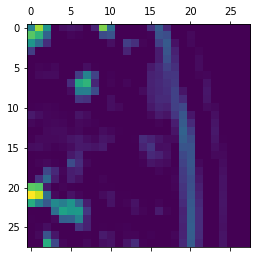

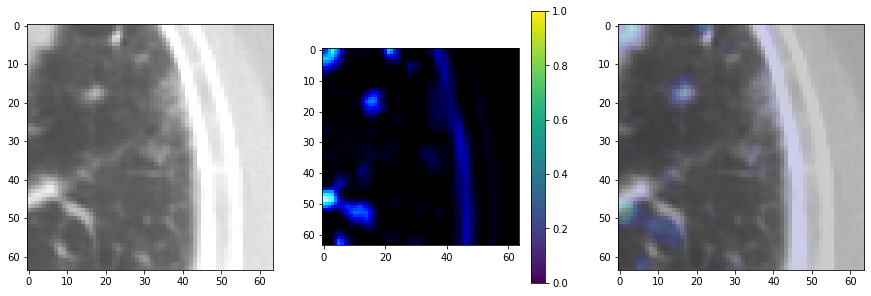

- Probabilidad clase maligna: 0.4180139
- Clase real: maligna






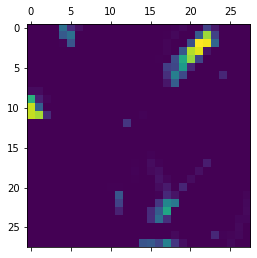

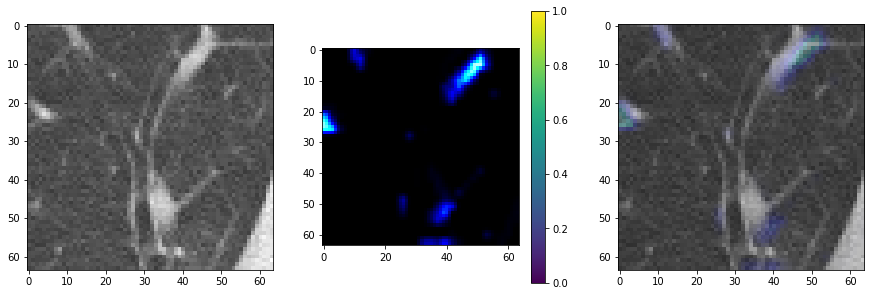

- Probabilidad clase maligna: 0.0020355124
- Clase real: benigna






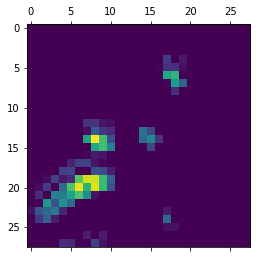

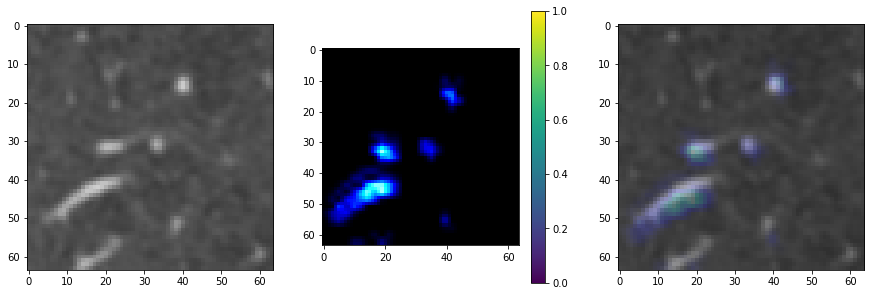

- Probabilidad clase maligna: 0.009389956
- Clase real: benigna






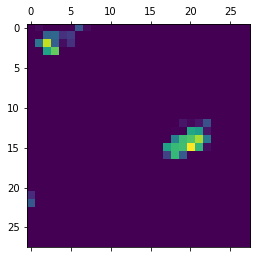

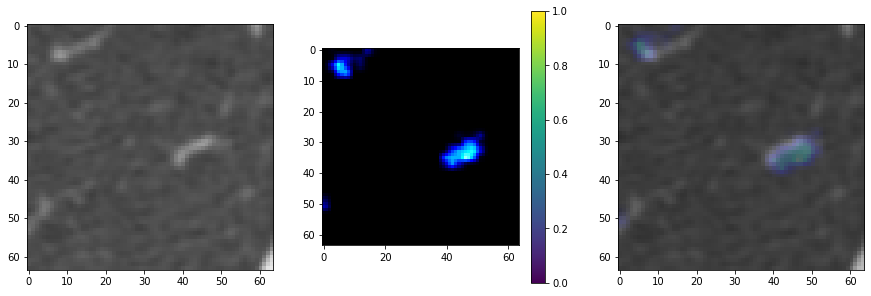

- Probabilidad clase maligna: 0.08023409
- Clase real: benigna






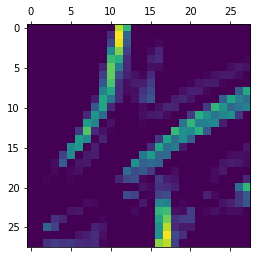

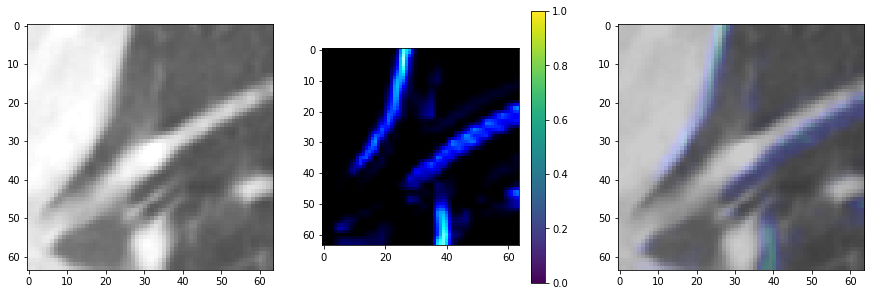

- Probabilidad clase maligna: 0.010368293
- Clase real: benigna






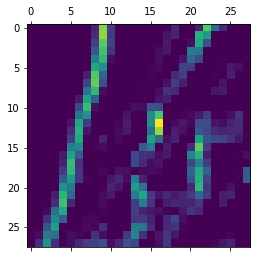

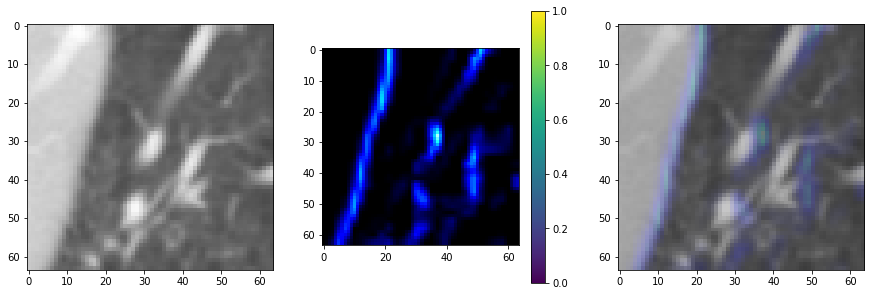

- Probabilidad clase maligna: 0.07759564
- Clase real: benigna






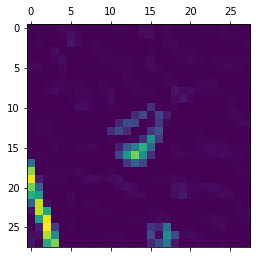

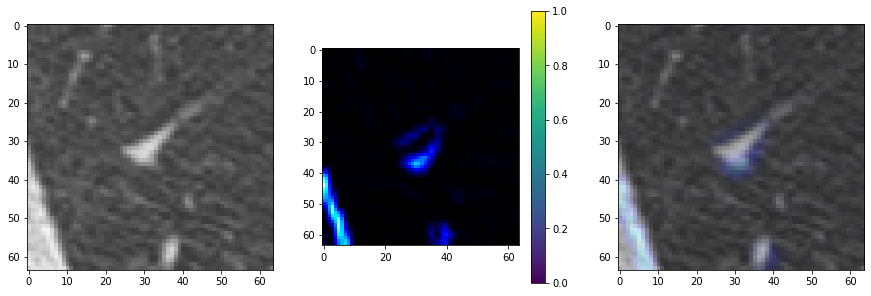

- Probabilidad clase maligna: 0.92069465
- Clase real: maligna






In [192]:
ind = 0
for i in range(ind, ind+10):
    heat_map, superimposed_img = show_heatmap(model, X_test[i], y_test[i,1])